In [1]:
import os
os.chdir("..")  
# print(os.getcwd())  

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import numpy as np

In [3]:
g1 = np.random.normal(loc=0.0, size=(500,2))
g2 = np.random.normal(loc=0.0, size=(500,2))
X_train = np.concatenate((g1, g2))
print(len(X_train))

1000


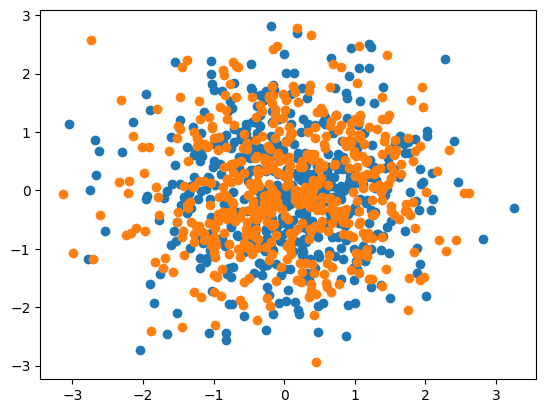

In [4]:
x1, y1 = g1.T
x2, y2 = g2.T

plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.savefig("images/gmm_original")

In [5]:
gmm = GaussianMixture(n_components=2)
gmm.fit(X_train)

GaussianMixture(n_components=2)

In [6]:
gmm.means_, gmm.weights_, gmm.covariances_

(array([[ 0.21782647,  0.66363032],
        [-0.11857453, -0.61648883]]),
 array([0.48217566, 0.51782434]),
 array([[[ 0.99676567, -0.14202995],
         [-0.14202995,  0.64414923]],
 
        [[ 0.99693573, -0.02724976],
         [-0.02724976,  0.59196844]]]))

In [7]:
def kl(mu_p, sigma_p, mu_q, sigma_q):
    k = mu_p.shape[-1]
    term_1 = np.log(np.linalg.det(sigma_q) / np.linalg.det(sigma_p))
    term_2 = (mu_q - mu_p).T @ np.linalg.inv(sigma_q) @ (mu_q - mu_p)
    term_3 = np.trace(np.linalg.inv(sigma_q) @ sigma_p)
    terms = term_1 - k + term_2 + term_3
    return 0.5 * terms

def mult_norms(mu_1, sigma_1, mu_2, sigma_2):
    inv = np.linalg.inv(sigma_1 + sigma_2)
    sigma = sigma_1 @ inv @ sigma_2
    mu = sigma_2 @ inv @ mu_1 + sigma_1 @ inv @ mu_2
    return mu, sigma

def l2(alpha, mu_p, sigma_p, beta, mu_q, sigma_q):
    distance = 0
    k = len(alpha)
    for i in range(k):
        for j in range(k):
            x, mu, sigma = mu_p[i], mu_p[j], sigma_p[i] + sigma_p[j]
            n1 = multivariate_normal.pdf(x, mean=mu, cov=sigma)
            distance += alpha[i] * alpha[j] * n1
    for i in range(k):
        for j in range(k):
            x, mu, sigma = mu_q[i], mu_q[j], sigma_q[i] + sigma_q[j]
            n2 = multivariate_normal.pdf(x, mean=mu, cov=sigma)
            distance += beta[i] * beta[j] * n2
    for i in range(k):
        for j in range(k):
            x, mu, sigma = mu_p[i], mu_q[j], sigma_p[i] + sigma_q[j]
            n3 = multivariate_normal.pdf(x, mean=mu, cov=sigma)
            distance -= 2*alpha[i] * beta[j] * n3
    return distance

n_components = 2
g = [g1, g2]
g_means_ = np.array([np.mean(g[0], axis=0), np.mean(g[1], axis=0)])
g_covariances_ = np.array([np.cov(g[0].T), np.cov(g[1].T)])
g_weights_ = np.array([0.5, 0.5])

print(l2(gmm.weights_, gmm.means_, gmm.covariances_, g_weights_, g_means_, g_covariances_))
print(l2(gmm.weights_, gmm.means_, gmm.covariances_, gmm.weights_, gmm.means_, gmm.covariances_))

0.00045442187631877795
-6.938893903907228e-18


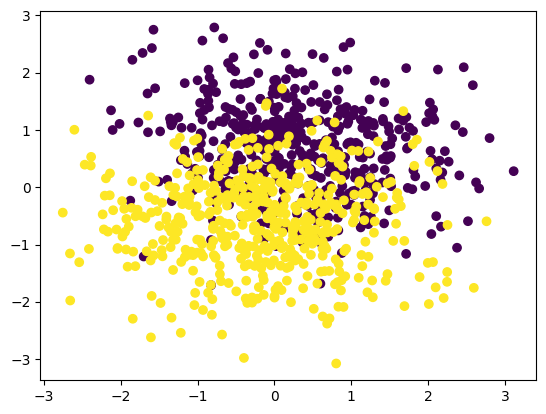

In [8]:
X, y = gmm.sample(1000)
plt.scatter(X[:,0], X[:,1], c=y)
plt.savefig("images/gmm_0")

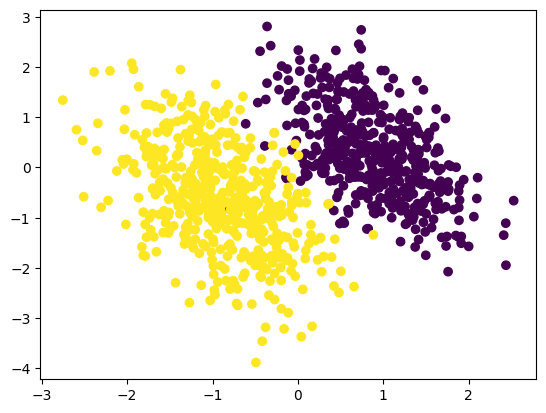

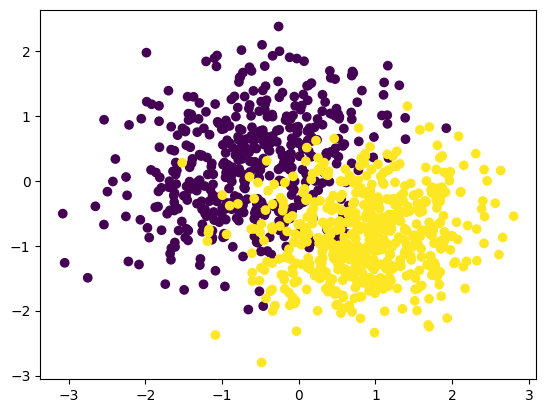

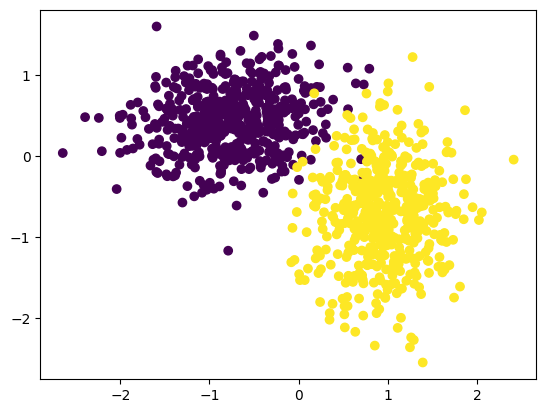

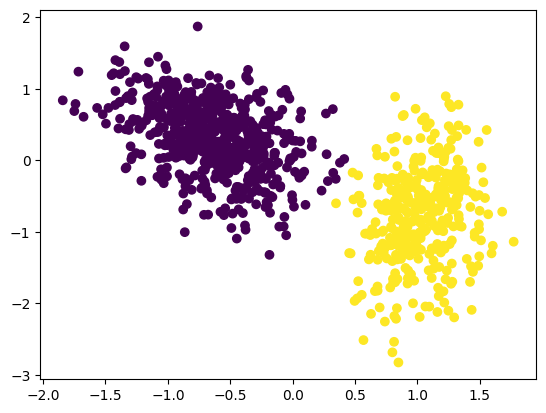

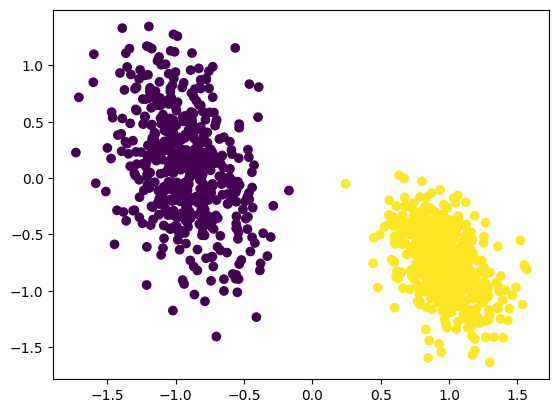

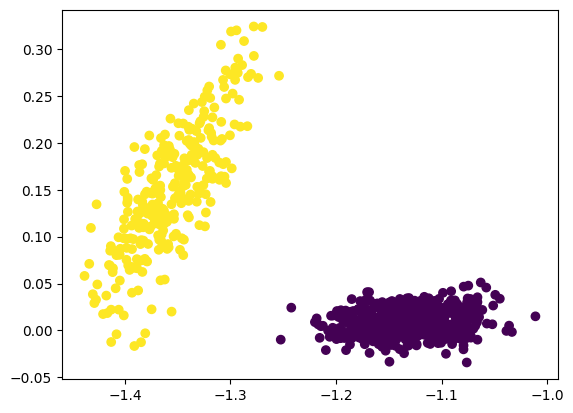

In [9]:
checkpoints = [50, 100, 150, 200, 350, 2000]
for i in range(2000):
    gmm = GaussianMixture(n_components=2)
    gmm.fit(X)
    X, y = gmm.sample(1000)
    if i+1 in checkpoints:
        plt.scatter(X[:,0], X[:,1], c=y)
        plt.savefig(f"images/gmm_{i+1}")
        plt.show()

In [10]:
sample_sizes = [500, 1000, 10000, 50000, 200000]
distances = [[],[],[],[],[]]
distances2 = [[],[],[],[],[]]
n_components = 2
for i, sample_size in enumerate(sample_sizes):
    print(f"Sample size {sample_size}")
    g1 = np.random.normal(loc=1.0, size=(sample_size//2,2))
    g2 = np.random.normal(loc=-1.0, size=(sample_size//2,2))
    X_train = np.concatenate((g1, g2))

    gmm_0 = GaussianMixture(n_components=n_components)
    gmm_0.fit(X_train)
    X, y = gmm_0.sample(sample_size)
    dist = np.log(l2(gmm_0.weights_, gmm_0.means_, gmm_0.covariances_, gmm_0.weights_, gmm_0.means_, gmm_0.covariances_)**2)
    # dist = np.sum([kl(gmm_0.means_[i], gmm_0.covariances_[i], gmm_0.means_[i], gmm_0.covariances_[i]) for i in range(n_components)])
    distances[i].append(dist)
    # distances[i].append(np.mean(np.linalg.norm(X-X_train, axis=1)))

    for _ in range(2000):
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(X)
        X, y = gmm.sample(sample_size)
        dist = np.log(l2(gmm.weights_, gmm.means_, gmm.covariances_, gmm_0.weights_, gmm_0.means_, gmm_0.covariances_)**2)
        # dist = np.sum([kl(gmm.means_[i], gmm.covariances_[i], gmm.means_[i], gmm.covariances_[i]) for i in range(n_components)])
        distances[i].append(dist)
        # distances[i].append(np.mean(np.linalg.norm(X-X_train, axis=1)))

Sample size 500


C:\Users\darkn\AppData\Local\Temp\ipykernel_30952\2891006053.py:14: RuntimeWarning: divide by zero encountered in log
  dist = np.log(l2(gmm_0.weights_, gmm_0.means_, gmm_0.covariances_, gmm_0.weights_, gmm_0.means_, gmm_0.covariances_)**2)


Sample size 1000
Sample size 10000
Sample size 50000


C:\Users\darkn\AppData\Local\Temp\ipykernel_30952\2891006053.py:14: RuntimeWarning: divide by zero encountered in log
  dist = np.log(l2(gmm_0.weights_, gmm_0.means_, gmm_0.covariances_, gmm_0.weights_, gmm_0.means_, gmm_0.covariances_)**2)


Sample size 200000


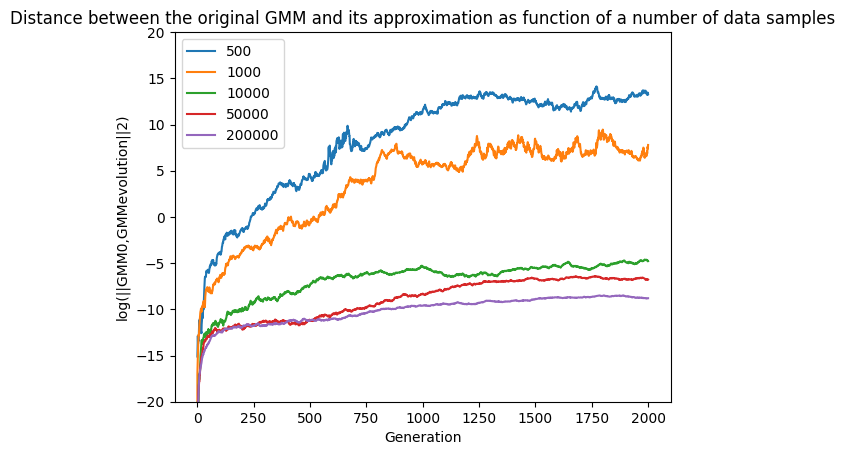

In [11]:
for i, distance in enumerate(distances):
    plt.plot(distance, label=f"{sample_sizes[i]}")
plt.title("Distance between the original GMM and its approximation as function of a number of data samples")
plt.ylabel("log(||GMM0,GMMevolution||2)")
plt.xlabel("Generation")
plt.ylim(-20, 20)
plt.legend()
plt.savefig("images/gmm_distance_graph")

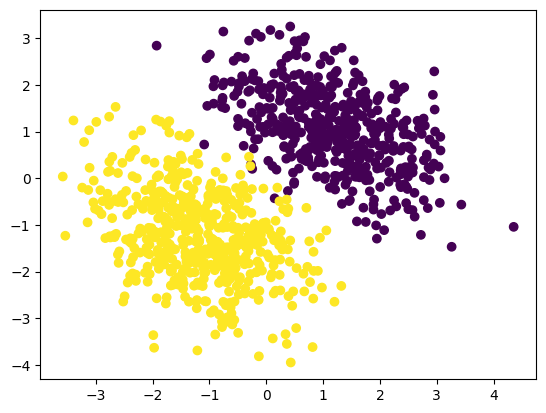

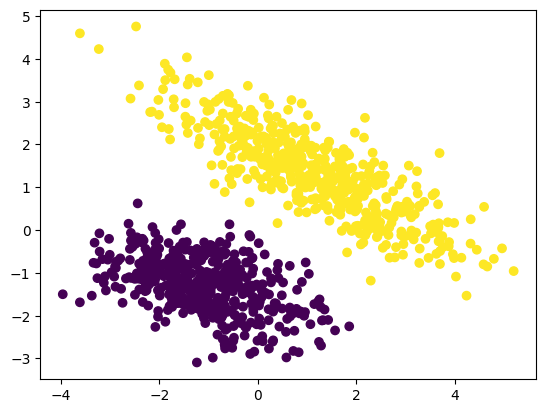

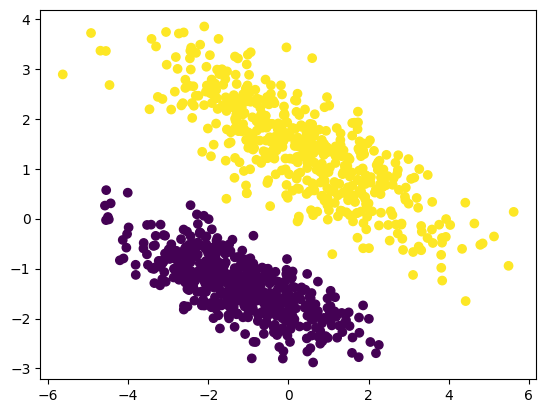

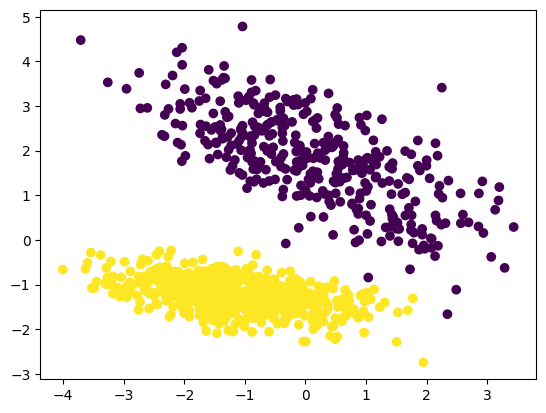

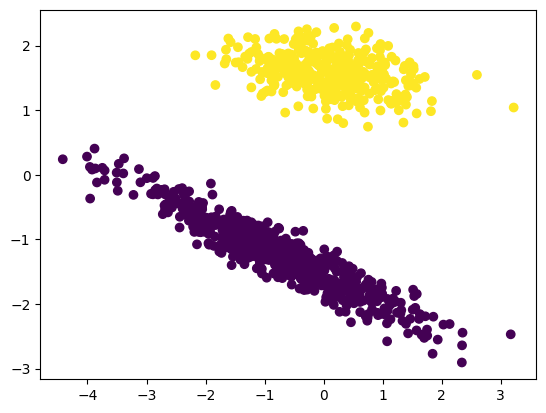

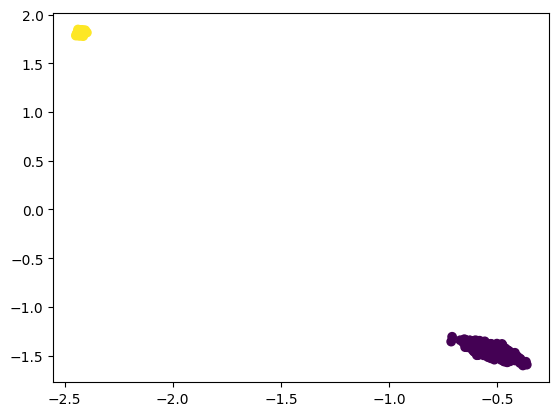

In [12]:
g1 = np.random.normal(loc=1.0, size=(500,2))
g2 = np.random.normal(loc=-1.0, size=(500,2))
X_train = np.concatenate((g1, g2))

gmm = GaussianMixture(n_components=2)
gmm.fit(X_train)

X, y = gmm.sample(1000)
X += np.random.normal(loc=0, size=(1000,2)) * 0.1
checkpoints = [50, 100, 150, 200, 350, 2000]
for i in range(2000):
    gmm = GaussianMixture(n_components=2)
    gmm.fit(X)
    X, y = gmm.sample(1000)
    if i+1 in checkpoints:
        plt.scatter(X[:,0], X[:,1], c=y)
        plt.savefig(f"images/gmm_noise_{i+1}")
        plt.show()